In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import requests
import json
from pprint import pprint
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress

In [2]:
pd.set_option('display.max_columns', None)

# Loading Data

### Parameter to change the metropolitan zone

In [8]:
zm_n=21

In [9]:
zm=pd.read_excel(f"/Volumes/TOSHIBA EXT/BootCamp/ZMs/ZM_{zm_n}.xlsx")

In [10]:
metros2=pd.read_excel(f"/Volumes/TOSHIBA EXT/BootCamp/ZMs/ZM_{zm_n}.xlsx")

### Importing Metropolitan Zone Valle de Mexico shapefiles

The shapefiles can be downloaded in the next <a href="https://inegi.org.mx/app/biblioteca/ficha.html?upc=889463807469">link</a>. 

### Load Mty

In [136]:
folder='19_nuevoleon'
mun='19'

data_sh=gpd.read_file(f"/Volumes/TOSHIBA EXT/BootCamp/Shapes/{folder}/conjunto_de_datos/{mun}a.shp")

### Load Gdl

In [11]:
folder='14_jalisco'
mun='14'

data_sh=gpd.read_file(f"/Volumes/TOSHIBA EXT/BootCamp/Shapes/{folder}/conjunto_de_datos/{mun}a.shp")

### Load EdoMex and CDMX

In [5]:
folder='15_mexico'
mun='15'

data_sh_15=gpd.read_file(f"/Volumes/TOSHIBA EXT/BootCamp/Shapes/{folder}/conjunto_de_datos/{mun}a.shp")

In [6]:
folder='09_ciudaddemexico'
mun='09'

data_sh_09=gpd.read_file(f"/Volumes/TOSHIBA EXT/BootCamp/Shapes/{folder}/conjunto_de_datos/{mun}a.shp")

data_sh=data_sh_15.append(data_sh_09)

In [12]:
data_sh.head(3)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry
0,1400100010141,14,001,0001,0141,"POLYGON ((2406407.173 974638.402, 2406337.420 ..."
1,140010001018A,14,001,0001,018A,"POLYGON ((2404583.405 974679.044, 2404594.899 ..."
2,1400100010160,14,001,0001,0160,"POLYGON ((2405932.292 975894.730, 2405873.336 ..."


In [13]:
data_sh.CVE_ENT.unique()

array(['14'], dtype=object)

In [14]:
data_sh['ent']=[int(i) for i in data_sh['CVE_ENT']]
data_sh['mun']=[int(i) for i in data_sh['CVE_MUN']]
data_sh['clave']=data_sh['ent']*1000+data_sh['mun']

In [15]:
data_sh['ZM']=[i in set(zm.clave) for i in data_sh['clave']]

In [16]:
data_sh=data_sh[data_sh['ZM']==True]

### Importing points from the scrapping

In [17]:
hh_points=pd.read_csv(f"/Volumes/TOSHIBA EXT/BootCamp/Datos/MetrosCubicos/data_ZM_{zm_n}_2021_6_19_geoloc.csv")

In [18]:
print(hh_points.shape)
hh_points.head(2)

(2279, 8)


,Unnamed: 0,p_m,m2,price,adress,url,lat,lng
0,0,16727.272727,220,3680000,"isla pantenaria 1956, residencial la cruz, gua...",https://casa.metroscubicos.com/MLM-913291399-h...,20.634387,-103.380825
1,1,11140.583554,377,4200000,"monte san elias 1878, colonial independencia ...",https://casa.metroscubicos.com/MLM-905368396-c...,20.707134,-103.331633


### Dropping nulls

In [19]:
cl_lat=(hh_points.lat.isnull())
cl_lng=(hh_points.lng.isnull())

hh_points=hh_points[~(cl_lat|cl_lng)]
print(hh_points.shape)
hh_points['lat'].isnull().sum()

(2237, 8)


0

### Changing lat and lng to geometry

In [20]:
geometry =[Point(xy) for xy in zip(hh_points['lng'],hh_points['lat'])]
crs={'init':'epsg:4326'}
hh_gpd=gpd.GeoDataFrame(hh_points,crs=crs,geometry=geometry)
# Get only manhattan subway stations using the manhattan geometry

/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [21]:
data_sh.crs

<Projected CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["GCS_ITRF_200 ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [22]:
data_sh.to_crs('epsg:4326',inplace=True)

In [23]:
hh_gpd = sjoin(hh_gpd, data_sh, op='within')

<ipython-input-23-1eb60e476afc>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  hh_gpd = sjoin(hh_gpd, data_sh, op='within')


In [24]:
data_sh[data_sh['CVEGEO']=='1405100010162']

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry,ent,mun,clave,ZM
1621,1405100010162,14,051,0001,0162,"POLYGON ((-103.16231 20.50482, -103.16233 20.5...",14,51,14051,True


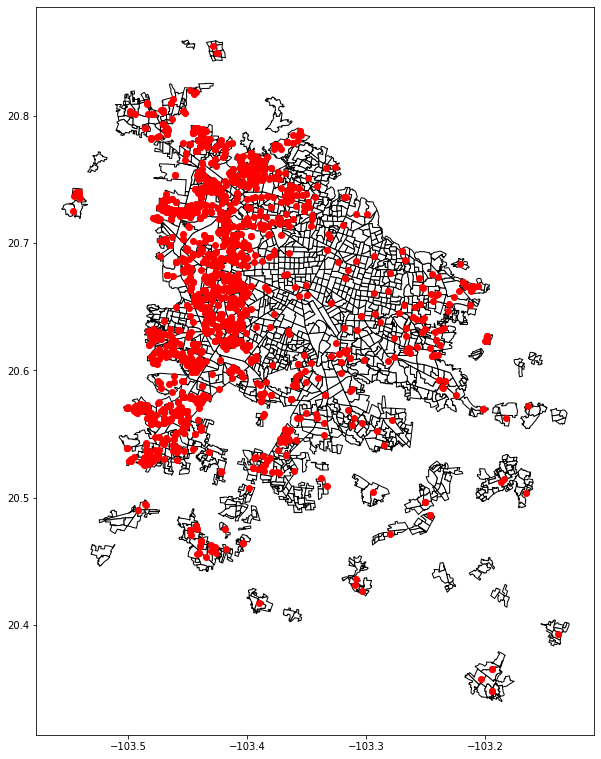

In [28]:
ax = data_sh.plot(color='white', edgecolor='black',figsize=(10,15))

# We can now plot our ``GeoDataFrame``.
hh_gpd.plot(ax=ax, color='red')
#data_sh[data_sh['CVEGEO']=='1405100010162'].plot(ax=ax,color='blue', edgecolor='black',figsize=(10,15))

plt.show()

In [130]:
variables=[
 'p_m',
 'm2',
 'price',
 'adress',
 'url',
 'lat',
 'lng',
 'geometry',
 'index_right',
 'CVEGEO',
 'CVE_ENT',
 'CVE_MUN',
 'CVE_LOC',
 'CVE_AGEB',
 'ZM']

### Exporting data

In [167]:
hh_gpd[variables].to_csv(f"/Volumes/TOSHIBA EXT/BootCamp/Datos/MetrosCubicos/data_ZM_{zm_n}_geoloc.csv")

In [67]:
data=hh_gpd[
 ['p_m',
 'CVEGEO',
 'clave',
 'ZM']]

data['ZM']=zm_n

data.columns= data.columns.str.lower()

data.rename(columns={'cvegeo':'id'},inplace=True)

data=data.groupby(['clave','id'],as_index=False).mean()

data.head()

<ipython-input-67-8f5cf13da33a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ZM']=zm_n
/Users/rafa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,clave,id,p_m,zm
0,9002,0900200010148,13475.601466,13
1,9002,0900200010260,6872.198179,13
2,9002,0900200010330,21400.778210,13
3,9002,090020001035A,11475.576037,13
4,9002,0900200010398,13541.666667,13


### Distribution of price per square meter

<AxesSubplot:ylabel='Frequency'>

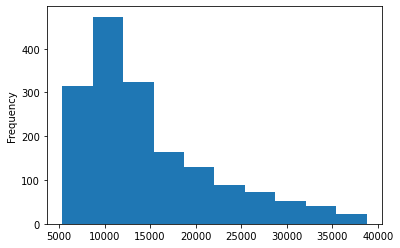

In [68]:
data.p_m.plot.hist()

In [69]:
path=f'/Volumes/TOSHIBA EXT/BootCamp/Datos/MetrosCubicos/precios_{zm_n}.csv'
data.to_csv(path,index=False)

In [111]:
data_sh.head(2)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry,clave,ZM
930,1403900012696,14,39,0001,2696,"POLYGON ((-103.37645 20.63875, -103.37680 20.6...",14039,True
931,1403900014207,14,39,0001,4207,"POLYGON ((-103.27836 20.69867, -103.27858 20.6...",14039,True


In [112]:
data_sh.to_file(f"/Volumes/TOSHIBA EXT/BootCamp/Shapes/zms/zm_{zm_n}.shp")